In [1]:
import tarfile
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy.random import rand
from numpy import log, exp, matmul

In [2]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz")
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz")
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz")
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz");

In [3]:
trainxs[:,:,0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

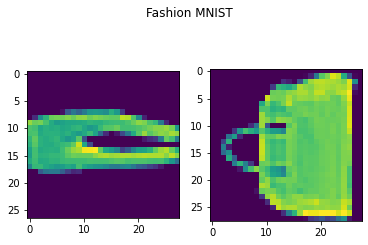

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fashion MNIST')
ax1.imshow(trainxs[1:,:,0])
ax2.imshow(trainxs[:,:,7])

In [82]:
trainxs.shape[0]

28

In [83]:
trainxs.shape[1]

28

In [84]:
trainxs.shape[2]

12000

In [85]:
trainxs.shape[0] * trainxs.shape[1]

784

# Q 3.2

In [86]:
sigmoid = lambda x : 1/(1 + exp(-x))
sigPrime = lambda x : sig(x)*(1 - sig(x))

In [115]:
inputPar = trainxs.shape[0] * trainxs.shape[1]
W = np.random.rand(2, inputPar)/100
b = np.zeros(2)

lr = {'W': np.random.rand(2, inputPar)/100,
       'b': np.zeros((2, 1))}
lr['b'].shape

(2, 1)

In [116]:
grad_lr = copy.deepcopy(lr)
fdgrad_lr = copy.deepcopy(lr)
diff_grad_lr = copy.deepcopy(lr)

In [170]:
a = lambda m, x : matmul(m['W'], x) + m['b']
f = lambda m, x : sigmoid(a(m,x))[0,0]

In [171]:
loss = lambda m, x, y: np.square(np.subtract(y,f(m, x)))/2

In [172]:
sample1 = trainxs.reshape(784, 1,12000)[:,:, 7]
sample1y = trainys[7]

In [173]:
sample1

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.01814136],
       [0.09657274],
       [0.394

In [174]:
sample1y

1

In [175]:
grad_lr

{'W': array([[0.00829756, 0.00778548, 0.00651337, ..., 0.00532482, 0.00363465,
         0.00041744],
        [0.00824018, 0.00546613, 0.0044832 , ..., 0.00962182, 0.00401487,
         0.00019641]]),
 'b': array([[0.],
        [0.]])}

In [176]:
lr['W'].shape

(2, 784)

In [177]:
check_lr = {'W': False,
             'b': False,}


lst = []
eps = 0.0000000001

for key, value in lr.items():
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            temp = value[i,j]
            #print(temp)
            value[i,j] += eps/2
            r = loss(lr, sample1, trainys[0])
            value[i,j] = temp
            value[i,j] -= eps/2
            l = loss(lr, sample1, trainys[0])
            value[i,j] = temp
            
            fdgrad_lr[key][i,j] = (r-l)/(eps)

            diff_grad_lr[key][i,j] = abs(fdgrad_lr[key][i,j] - grad_lr[key][i,j])
            
            if((key == 'W') and (diff_grad_lr[key][i,j] != 0)):
                lst.append(diff_grad_lr[key][i,j])
    check_lr[key] = (diff_grad_lr[key] < 0.05).all()
    

In [178]:
print(fdgrad_lr)

print("Error: ", diff_grad_lr)
print(check_lr)

print(len(lst))
print(np.average(lst))

{'W': array([[0.        , 0.        , 0.        , ..., 0.00737799, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]]), 'b': array([[0.12041423],
       [0.        ]])}
Error:  {'W': array([[0.00829756, 0.00778548, 0.00651337, ..., 0.00205317, 0.00363465,
        0.00041744],
       [0.00824018, 0.00546613, 0.0044832 , ..., 0.00962182, 0.00401487,
        0.00019641]]), 'b': array([[0.12041423],
       [0.        ]])}
{'W': False, 'b': False}
1568
0.026811596766321565


In [144]:

sample1 = trainxs.reshape(784, 1,12000)[:,:, 3000]
sample1y = trainys[3000]

inputPar = trainxs.shape[0] * trainxs.shape[1]
hid1 = 64
hid2 = 32

#mlp = ThreeLayerPerceptron(hid1, hid2, inputPar) 
#grad_mlp = ThreeLayerPerceptron(hid1, hid2, inputPar)
#print(mlp.W1.shape, b1.shape, W2.shape, b2.shape, W3.shape)

mlp = {'W1': rand(hid1, inputPar)/100,
       'b1': np.zeros((hid1, 1)),
       'W2': rand(hid2, hid1)/100,
       'b2': np.zeros((hid2, 1)),
       'W3': rand(hid2, 1)/100,
       'b3': np.zeros((1,1))}

grad_mlp = copy.deepcopy(mlp)
fdgrad_mlp = copy.deepcopy(mlp)
diff_grad_mlp = copy.deepcopy(mlp)
check_mlp = {'W1': False,
             'b1': False,
             'W2': False,
             'b2': False,
             'W3': False,
             'b3': False}


#print("W1 = ", mlp['W1'].shape)
#print("b1 = ", mlp['b1'].shape)
#print("W2 = ", mlp['W2'].shape)
#print("b2 = ", mlp['b2'].shape)
#print("W3 = ", mlp['W3'].shape)

sig = lambda x : 1/(1 + exp(-x))
sigPrime = lambda x : sig(x)*(1 - sig(x))

a1 = lambda m, x : matmul(m['W1'], x) + m['b1']
h1 = lambda m, x : sig(a1(m,x))
a2 = lambda m, x : matmul(m['W2'], h1(m,x)) + m['b2']
h2 = lambda m, x : sig(a2(m,x))
a3 = lambda m, x : matmul(m['W3'].T, h2(m,x)) + m['b3'][0,0]
f = h3 = lambda m, x : sig(a3(m,x))[0,0]

loss = lambda m, x, y: -log((1 - f(m, x))**(1 - y)) - log(f(m, x)**y)

#print("f = ", f(mlp, sample1))
#print("Loss = ", loss(mlp, sample1, trainys[0]))

######## Analytica Gradient of Parameters #########

#grad_mlp['W3'] = (h3(mlp, sample1) - sample1y) * h2(mlp, sample1)
#print(grad_mlp['W3'].shape)
#grad_mlp['b3'][0,0] = (h3(mlp, sample1) - sample1y)
#
#grad_mlp['W2'] = (h3(mlp, sample1) - sample1y) * mlp['W3'] @ h2(mlp, sample1).T @ (1 - h2(mlp, sample1)) @ h1(mlp, sample1).T
#print(grad_mlp['W2'].shape)
#grad_mlp['b2'] = (h3(mlp, sample1) - sample1y) * mlp['W3'] @ h2(mlp, sample1).T @ (1 - h2(mlp, sample1))
#
#grad_mlp['W1'] = (((h3(mlp, sample1) - sample1y) * mlp['W3'] @ h2(mlp, sample1).T @ (1 - h2(mlp, sample1))).T @ mlp['W2']).T @ h1(mlp, sample1).T @ (1 - h1(mlp, sample1)) @ sample1.T
#print((grad_mlp['W1'] ).shape)
#grad_mlp['b1'] = (((h3(mlp, sample1) - sample1y) * mlp['W3'] @ h2(mlp, sample1).T @ (1 - h2(mlp, sample1))).T @  mlp['W2']).T @ h1(mlp, sample1).T @ (1 - h1(mlp, sample1))



grad_mlp['b3'][0,0] = h3(mlp, sample1) - sample1y
#print(grad_mlp['b3'][0,0])
grad_mlp['W3'] = (h3(mlp, sample1) - sample1y) * h2(mlp, sample1)
#print(grad_mlp['W3'].shape)

grad_mlp['b2'] = grad_mlp['b3'][0,0] * h2(mlp, sample1) @ (1 - h2(mlp, sample1)).T @ mlp['W3']
grad_mlp['W2'] = (h1(mlp, sample1) @ grad_mlp['b2'].T).T
#print(grad_mlp['W2'].shape)

grad_mlp['b1'] = h1(mlp, sample1) @ (1 - h1(mlp, sample1)).T @  mlp['W2'].T @ grad_mlp['b2']
grad_mlp['W1'] =  (sample1 @ grad_mlp['b1'].T).T
#print((grad_mlp['W1'] ).shape)


#grad_mlp['b3'][0,0] = h3(mlp, sample1) - sample1y
#print(grad_mlp['b3'][0,0])
#grad_mlp['W3'] = (h3(mlp, sample1) - sample1y) * h2(mlp, sample1)
#print(grad_mlp['W3'].shape)
#
#grad_mlp['b2'] = matmul(matmul(grad_mlp['b3'][0,0] * h2(mlp, sample1), (1 - h2(mlp, sample1)).T), mlp['W3'])
#grad_mlp['W2'] = matmul(h1(mlp, sample1), grad_mlp['b2'].T).T
#print(grad_mlp['W2'].shape)
#
#grad_mlp['b1'] = matmul(matmul(matmul(h1(mlp, sample1), (1 - h1(mlp, sample1)).T), mlp['W2'].T), grad_mlp['b2'])
#grad_mlp['W1'] =  matmul(sample1, grad_mlp['b1'].T).T
#print((grad_mlp['W1'] ).shape)


######## Finite Difference Gradient of Parameters #########

#temp = mlp['b3'][0]
#mlp['b3'][0] += eps/2
#r = loss(mlp, sample1, trainys[0])
#mlp['b3'][0] = temp
#mlp['b3'][0] -= eps/2
#l = loss(mlp, sample1, trainys[0])
#
#res = (r-l)/eps
#print("b3 = ", res)


#pars = [mlp.W1, mlp.b1, mlp.W2, mlp.b2, mlp.W3, [mlp.b3]]
lst = []
eps = 0.0000000001
for key, par in mlp.items():
    for i in range(par.shape[0]):
        for j in range(par.shape[1]):
            temp = par[i,j]
            #print(temp)
            par[i,j] += eps/2
            r = loss(mlp, sample1, trainys[0])
            par[i,j] = temp
            par[i,j] -= eps/2
            l = loss(mlp, sample1, trainys[0])
            par[i,j] = temp
            
            fdgrad_mlp[key][i,j] = (r-l)/(2*eps)

            diff_grad_mlp[key][i,j] = abs(fdgrad_mlp[key][i,j] - grad_mlp[key][i,j])
            
            if((key == 'W1') and (diff_grad_mlp[key][i,j] != 0)):
                lst.append(diff_grad_mlp[key][i,j])
    check_mlp[key] = (diff_grad_mlp[key] < 0.05).all()


In [145]:
print(fdgrad_mlp)

print("Error: ", diff_grad_mlp)
print(check_mlp)

print(len(lst))
print(np.average(lst))

{'W1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'b1': array([[1.05471187e-05],
       [1.05471187e-05],
       [8.32667268e-06],
       [8.32667268e-06],
       [1.05471187e-05],
       [9.43689571e-06],
       [1.05471187e-05],
       [1.16573418e-05],
       [1.05471187e-05],
       [9.43689571e-06],
       [8.32667268e-06],
       [8.32667268e-06],
       [8.32667268e-06],
       [1.05471187e-05],
       [1.05471187e-05],
       [8.32667268e-06],
       [1.05471187e-05],
       [8.32667268e-06],
       [9.43689571e-06],
       [8.32667268e-06],
       [1.05471187e-05],
       [8.32667268e-06],
       [1.05471187e-05],
       [1.05471187e-05],
       [8.32667268e-06],
       [1.16573418e-05],
       [9.43689571e-06],
       [9.43689571e-06],
       [8.32667268e-06],
       [1.05471187e-

# Q 3.3, 3.4

In [ ]:
def LogisticRegression(x, y):
    #W = np.zeros(2, inputPar)
    #b = np.zeros(2)
    inputPar = trainxs.shape[0] * trainxs.shape[1]
    W = np.zeros([2, inputPar])
    b = np.zeros(2)
    learningrate = 0.01
    precision = 0.00001
    previousstepsize = 1.0
    n = len(x)
    curx = 0
    
    while (previousstepsize > precision):
        y_pred = sigmoid(matmul(W, x) + b)
        D_w = -(1/n) * sum(x * (y - y_pred) * (y_pred) * (1-y_pred))
        
        W = W - learningrate * D_w
        previousstepsize = abs(curx - W)
        curx = W;
    return W;



In [ ]:
print(LogisticRegression(trainxs[:,:],trainys))

In [12]:
print(np.zeros((1,1)))

[[0.]]


In [6]:
trainxs.reshape(trainxs.shape[0]*trainxs.shape[1], 1, -1)

array([[[0.        , 0.1308131 , 0.08962205, ..., 0.04505032,
         0.        , 0.0014855 ]],

       [[0.        , 0.1308131 , 0.08962205, ..., 0.04505032,
         0.        , 0.0014855 ]],

       [[0.        , 0.1308131 , 0.08962205, ..., 0.04505032,
         0.        , 0.0014855 ]],

       ...,

       [[0.        , 0.1308131 , 0.08962205, ..., 0.04505032,
         0.        , 0.0014855 ]],

       [[0.        , 0.1308131 , 0.08962205, ..., 0.04505032,
         0.        , 0.0014855 ]],

       [[0.        , 0.1308131 , 0.08962205, ..., 0.04505032,
         0.        , 0.0014855 ]]])

In [ ]:
def showResults(epochsloss_train, loss_val, acc_train, acc_val, max_val_acc_epoch):
    print('The accuracy on the training and validation set, for the epoch on which we get the highest accuracy on the validation set is: {} / {} at epoch {}.'.format(acc_train[max_val_acc_epoch], acc_val[max_val_acc_epoch], max_val_acc_epoch+1))   

    plt.figure(figsize=(12, 5))
    plt.suptitle("Loss and Accuracy Results of Training and Validation set", fontsize = 16)

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_train, label="Training Loss")
    plt.plot(range(epochs), loss_val, label="Validation Loss")
    plt.xlabel('Epoch', fontsize = 13)
    plt.ylabel('Loss', fontsize = 13)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), acc_train, label="Training Accuracy")
    plt.plot(range(epochs), acc_val, label="Validation Accuracy")
    plt.xlabel('Epoch', fontsize = 13)
    plt.ylabel('Accuracy', fontsize = 13)
    plt.legend()

    plt.show()

In [20]:
def shuffleIdx(n):
    rng = default_rng()
    rand_idx = rng.permutation(n)
    return rand_idx

############################IMPORTANT PARAMETERS#############################
batch_size = 32
momentum = 1.0
patience = 10 #Parameter for early_stop, 10 means wait for 10 more epochs before stop, suggest 10 for stochastic but 5 for others
hidden = 64  #Hidden layer neurons
###################################

inputPar = trainxs.shape[0] * trainxs.shape[1]
mlp = {'W': np.random.rand(1, inputPar)/100,
       'b': np.zeros((1, 1))}

keys = iter(mlp)
layers_sizes = [inputPar, 1]

for s in range(len(layers_sizes)-1):
    key = next(keys)
    epsilon = 4.0 * np.sqrt(6) / np.sqrt(layers_sizes[s] + layers_sizes[s+1])
    mlp[key] = epsilon * ( (rand(layers_sizes[s+1], layers_sizes[s]) * 2.0 ) - 1)
#     print(key)
#     print(epsilon)
#     print(mlp[key])

grad_mlp = copy.deepcopy(mlp)

sig = lambda x : 1/(1 + exp(-x))
sigPrime = lambda x : sig(x)*(1 - sig(x))

a1 = lambda m, x : matmul(m['W1'], x) + m['b1'][0,0]
f = h1 = lambda m, x : sig(a1(m,x))[0,0]

loss = lambda m, x, y: (x * (y - f(m, x)) * (f(m, x)) * (1-f(m, x)))


########### LEARNING PROCESS ################
#epoch = 500
learning_rate = 0.01
trainysprime = []
# tlosslist_train = []
# tlosslist_val = []
# tacclist_train = []
# tacclist_val = []
best = 0
patience_cnt = 0



loss_train_list = []
loss_val_list = []
acc_train_list = []
acc_val_list = []
max_val_acc_epoch = 0
n_samples = trainxs.shape[2]
n_samples_val = devxs.shape[2]

for e in range(epoch):
    idx = shuffleIdx(X.shape[2])
    X = trainxs[:, :, idx]
    Y = trainys[idx]
    
    X_val = devxs[:,:,idx]
    Y_val = devys[:,:,idx]
    
    tloss_train = 0
    tloss_val = 0
    
    tacc_train = 0
    tacc_val = 0
    tr_true = 0
    val_true = 0
    cnt = 1
    
    total_grad = {'W': np.zeros((1, inputPar)),
             'b': np.zeros((1, 1)),}
    
    # UPDATING GRADIENTS FOR EACH IMAGE IN THE TRAINING DATASET
    for i in range(trainxs.shape[2]): #number of data
#         x = train_data[i][0].reshape(784, 1)
#         x = normalize(x)
#         y = train_data[i][1]
        x = X[:, :, i]
        y = Y[i]
        
        if f(mlp,x) >= 0.5:
            yprime = 1
        else:
            yprime = 0
            
        if yprime == y:
            tr_true += 1
            
        trainysprime.append(yprime)
        tloss_train += loss(mlp,x,y)
        tacc_train += f(mlp,x)
        
        grad_mlp['b'][0,0] = h1(mlp, x) - y
        grad_mlp['W'] = h1(mlp, x).T * grad_mlp['b']
        

        # SUMMING THE GRADIENTS OF X
        for key in mlp:
            tgrad[key] += grad_mlp[key]
            
            
        
#         #Mini gradient descent
#         if cnt == batch_size:
#             for key in tgrad:
#                 tgrad[key] = tgrad[key]/batch_size
#                 mlp[key] = momentum*mlp[key] - lr*tgrad[key] #With momenum
#             cnt = 1
#         else:
#             cnt+=1
                
            
    for j in range(devxs.shape[2]): #number of data
        x_val = X_val[:,:,i]
        y_val = Y_val[i]
                    
        if f(mlp,val_x) >= 0.5:
            yprime = 1
        else:
            yprime = 0
            
        if yprime == val_y:
            val_true += 1
            
        tloss_val += loss(mlp,val_x,val_y)
        tacc_val  += f(mlp,val_x)
            
    # FINDING THE AVERAGE OF GRADIENTS FOR EACH EPOCH SINCE WE ARE DOING FULL-BATCH GRADIENT DESCEND        
    # AND UPDATING THE PARAMETERS AFTER EACH EPOCH
    tloss_train = tloss_train/n_samples
    loss_train_list.append(tloss_train)
    
    #tacc_train = tacc_train/n_samp
    tloss_val = tloss_val/(n_samples_val)
    loss_val_list.append(tloss_val)
    
    tr_true = tr_true/n_samples_val
    val_true = val_true/(n_samples_val)
    
    #tacc_val = tacc_val/(devxs.shape[2])
    acc_train_list.append(tr_true)
    acc_val_list.append(val_true)
    
#     #EarlyStopping
#     if e == 1:
#         best = tloss_val
#     else:
#         best,patience_cnt = early_stop(best, tloss_val,patience_cnt)
#     if patience_cnt == patience:
#         print("Stopped by Early stopping")
#         print("Best validation loss: {}".format(best))
#         print("Trained epochs: {}".format(e))
#         break

    if  acc_val > acc_val_list[max_val_acc_epoch]:
        max_val_acc_epoch = e

 
    print("- Loss on Training / Validation Data at Epoch {}: {:.4f} / {:.4f}".format(e+1, tloss_train, tloss_val)) 
    print("- Accuracy on Training / Validation Data at Epoch {}: {} / {}\n".format(e+1, tr_true, val_true))

In [18]:
mlp['W'].shape

(1, 784)

In [23]:
f

<function __main__.<lambda>(m, x)>

In [24]:
h3

<function __main__.<lambda>(m, x)>